# 1. Import các Thư Viện Cần Thiết

In [15]:

import numpy as np 
import pandas as pd 
from scipy.stats import randint
import matplotlib.pyplot as plt 
from pandas import set_option
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics 
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import classification_report


# 2. Đọc Dữ Liệu và Kiểm Tra Thông Tin

In [16]:

BankCredit = pd.read_csv('UCI_Credit_Card.csv')
print(f'The shape of the dataframe is {BankCredit.shape}\n')
print(BankCredit.info())



The shape of the dataframe is (30000, 25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  f

In [17]:
BankCredit.replace(to_replace='?', value=np.NaN, inplace=True)
print(BankCredit.describe(include='all'))

                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802

# 3. Phân Tích Dữ Liệu Thăm Dò (EDA)

In [18]:
print(BankCredit['default.payment.next.month'].value_counts())
print(BankCredit.isnull().sum())

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


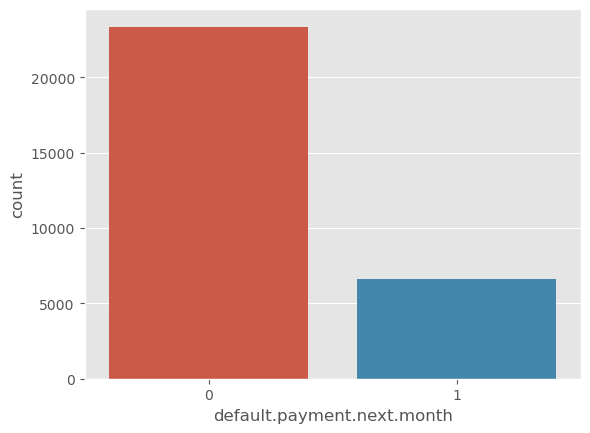

In [19]:
import seaborn as sns
sns.countplot(x='default.payment.next.month', data=BankCredit, linewidth=3)
plt.show()

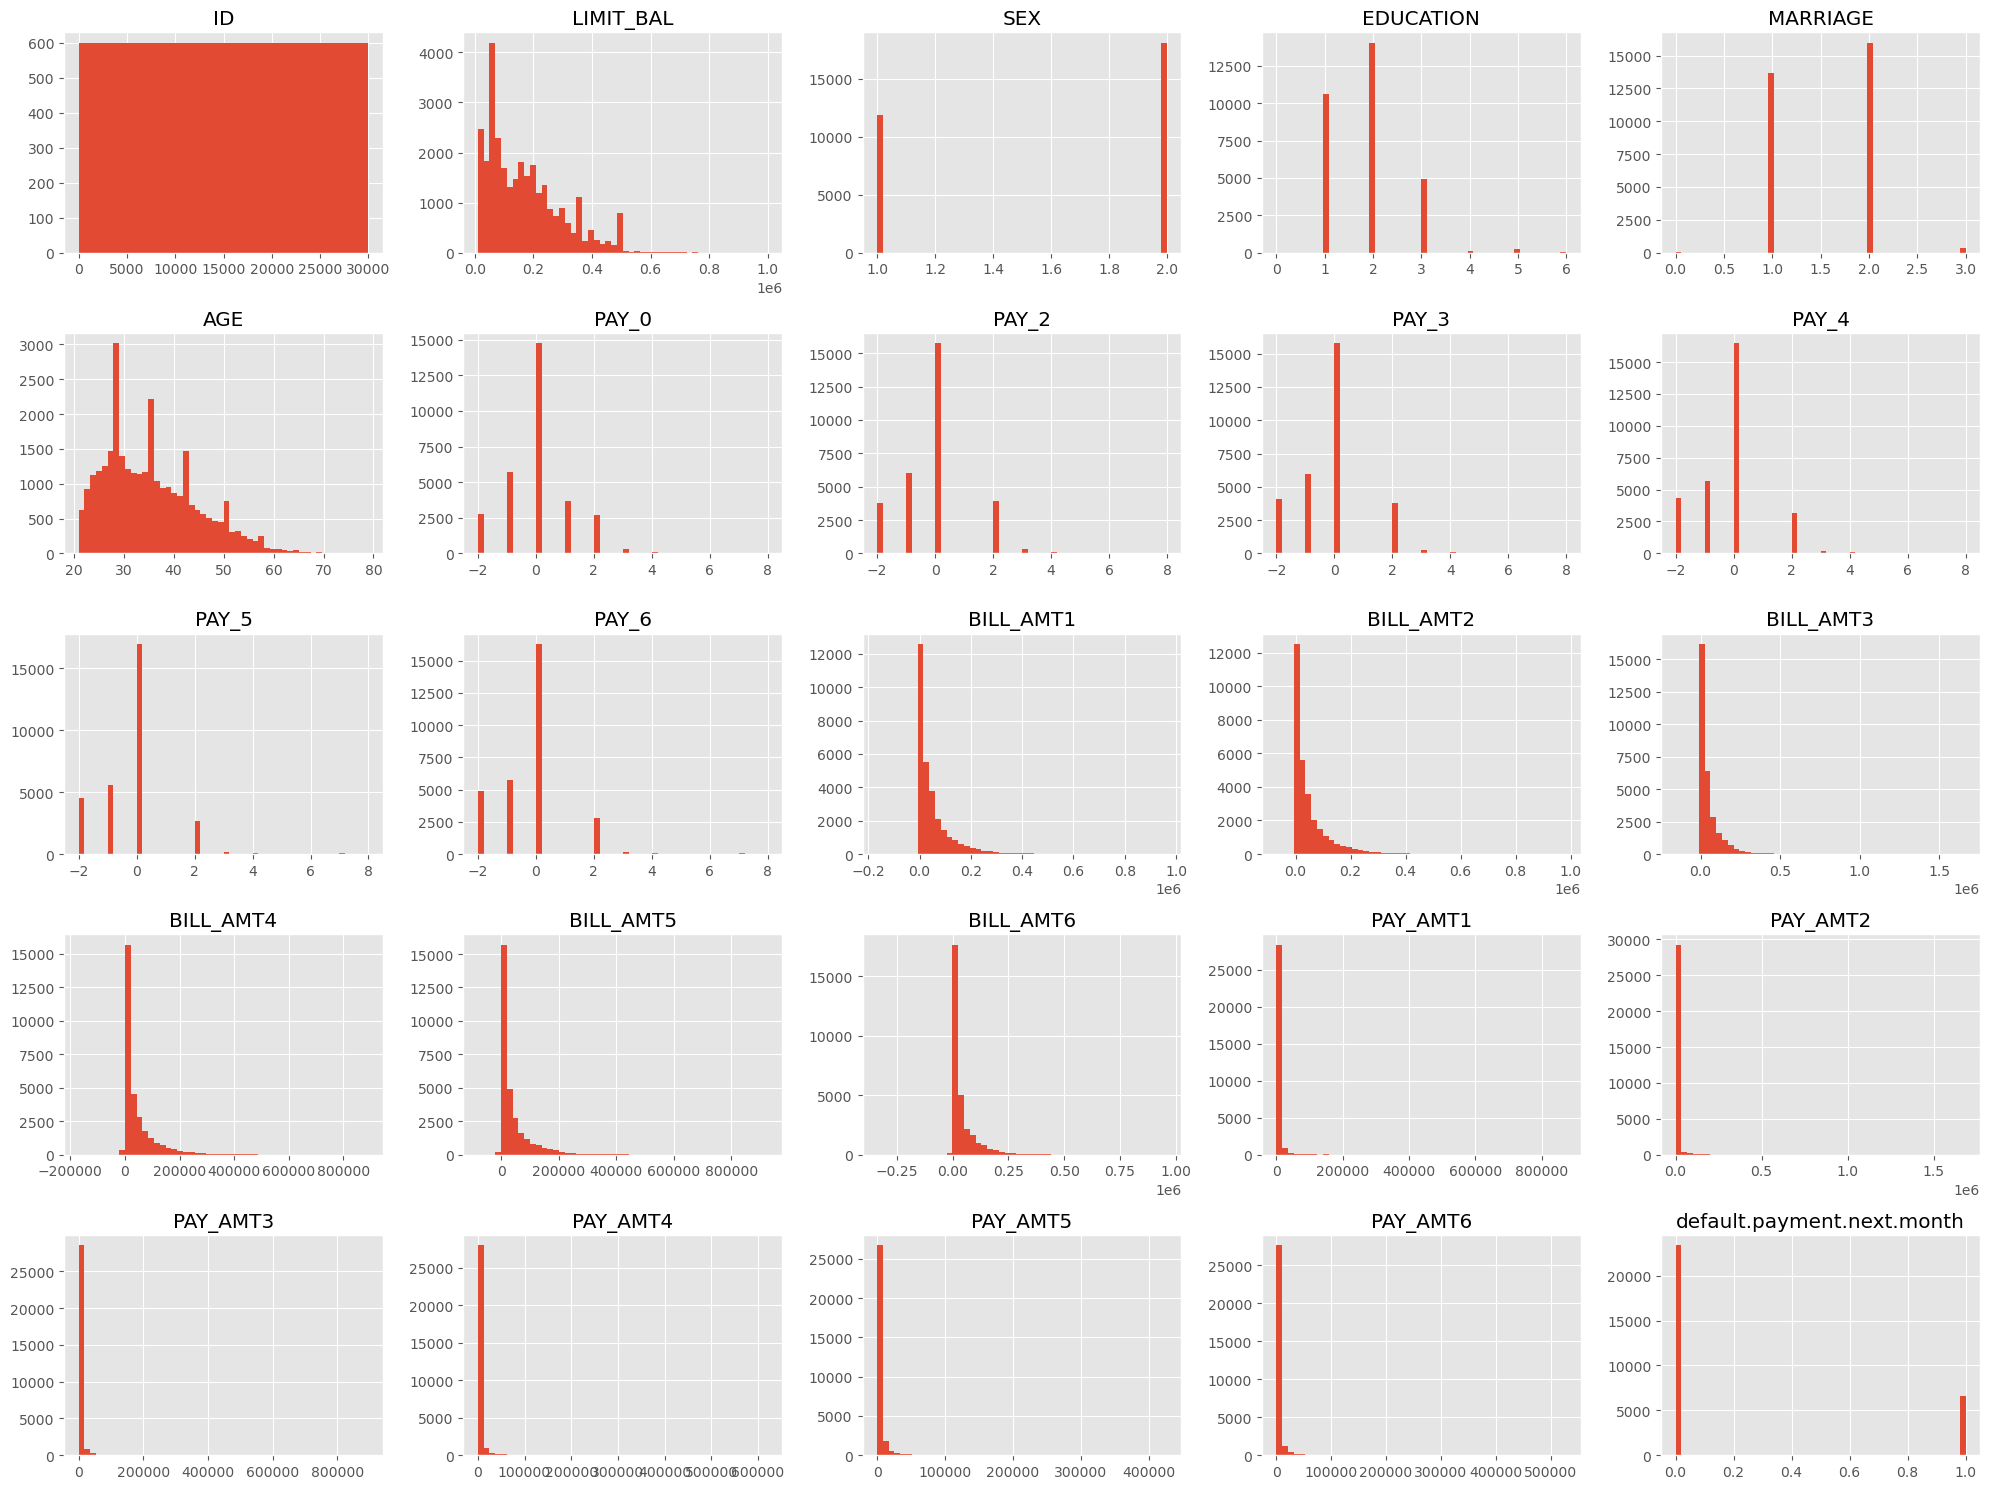

In [30]:

# BankCredit[['AGE', 'LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1']].hist(bins=50, figsize=(10, 6))
BankCredit.hist(bins=50, figsize=(20, 15))
plt.tight_layout() 
plt.show()


# 4. Chia Dữ Liệu và Xử Lý Thiếu

In [21]:
BankCredit['EDUCATION'].fillna(BankCredit['EDUCATION'].mode()[0], inplace=True)
BankCredit['MARRIAGE'].fillna(BankCredit['MARRIAGE'].mode()[0], inplace=True)
print(BankCredit.isnull().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [38]:
X = BankCredit.drop(['ID', 'default.payment.next.month'], axis=1)
y = BankCredit['default.payment.next.month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# 5. Mã Hóa One-Hot Encoding và Chuẩn Hóa Dữ Liệu

In [39]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
encoder = OneHotEncoder(sparse=False)
cols = ['SEX', 'EDUCATION', 'MARRIAGE']

X_train_encoded = encoder.fit_transform(X_train[cols])
X_test_encoded = encoder.transform(X_test[cols])

# Loại bỏ các cột gốc đã mã hóa và ghép lại dữ liệu.
X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)
X_train = pd.concat([X_train.reset_index(drop=True), 
                     pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), 
                    pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out())], axis=1)

# Chuẩn hóa dữ liệu với MinMaxScaler.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Huấn Luyện Mô Hình Gaussian Naive Bayes

In [32]:

from sklearn.naive_bayes import GaussianNB

model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)


GaussianNB()

# 7. Dự Báo và Đánh Giá Mô Hình

In [33]:
y_pred = model_gnb.predict(X_test)
print(y_pred)

[1 1 0 ... 1 1 1]


In [34]:
from sklearn.metrics import accuracy_score
print(f'Model accuracy score: {100 * accuracy_score(y_test, y_pred):.2f}%')

Model accuracy score: 28.51%


In [35]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 633 6376]
 [  58 1933]]


In [36]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.09      0.16      7009
           1       0.23      0.97      0.38      1991

    accuracy                           0.29      9000
   macro avg       0.57      0.53      0.27      9000
weighted avg       0.76      0.29      0.21      9000

